In [ ]:
import glob
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import numpy as np
import re
from xgboost import plot_importance
import matplotlib.pyplot as plt
import seaborn as sns

# glob.glob('data*.csv') - returns List[str]
# pd.read_csv(f) - returns pd.DataFrame()
# for f in glob.glob() - returns a List[DataFrames]
# pd.concat() - returns one pd.DataFrame()
df = pd.concat([pd.read_csv(f) for f in glob.glob('drive/My Drive/*.csv')], ignore_index = True)

print(df.tail())

#print(df[df['Total current'] == 0].shape[0])
df.drop(df[df['Total current'] == 0].index, inplace = True)
df.reset_index(drop=True, inplace=True)

df.datetime = pd.to_datetime(df.datetime, dayfirst = True)

'''df['month'] = df['datetime'].dt.month()
df['day'] = df['datetime'].dt.day()
df['hour'] = df['datetime'].dt.hour()
df['weekday'] = df['datetime'].dt.dayOfWeek()
print(type(df.datetime))
'''
df['month'] = pd.DatetimeIndex(df['datetime']).month
df['hour'] = pd.DatetimeIndex(df['datetime']).hour
df = df.drop('datetime', axis =1)
df.columns = df.columns.str.replace(' ', '')
print(df.tail())

print(df['Totalcurrent'].describe())

#df.rename(columns={"Familymembersinagegroup[65+yearsold]": "Familymembersinagegroup65yearsoldplus", "Familymembersinagegroup[45-64yearsold]": "Familymembersinagegroup45to64", "Familymembersinagegroup[25-44yearsold]": "Familymembersinagegroup25to44", "Familymembersinagegroup[18-24yearsold]": "Familymembersinagegroup18to24", "Familymembersinagegroup[10-17yearsold]": "Familymembersinagegroup10to17", "Familymembersinagegroup[5-9yearsold]": "Familymembersinagegroup5to9"})

regex = re.compile(r"\[|\]|<", re.IGNORECASE)
df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df.columns]

#X, y = df.iloc[:,:-1],df.iloc[:,-1]
X, y = df.drop('Totalcurrent', axis =1),df.loc[:,'Totalcurrent']
#data_dmatrix = xgb.DMatrix(data=X,label=y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2



xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.9, learning_rate = 0.05, max_depth = 18, alpha = 10, n_estimators = 1000, tree_method = 'gpu_hist')

xg_reg.fit(X_train,y_train)

test_pred = xg_reg.predict(X_test)
train_pred = xg_reg.predict(X_train)
valid_pred = xg_reg.predict(X_val)


In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, test_pred))
rmse_valid = np.sqrt(mean_squared_error(y_val, valid_pred))
print("RMSE: %f" % (rmse))
print("RMSE_Valid: %f" % (rmse_valid))

print(r2_score(y_test, test_pred))
print(r2_score(y_train, train_pred))
print(r2_score(y_val, valid_pred))


RMSE: 966.918217
RMSE_Valid: 967.454459
0.8589184513631758
0.9861562277576355
0.8597739182920505


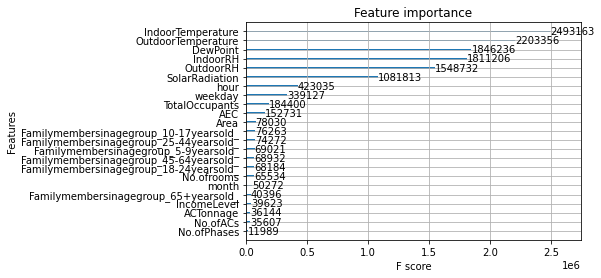

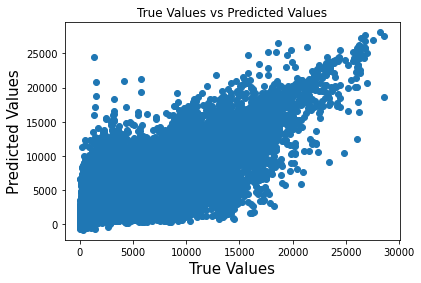

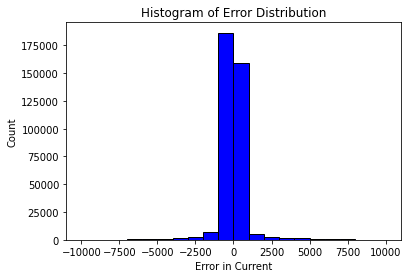

In [ ]:
plot_importance(xg_reg, max_num_features=25, show_values=True)

fig1 = plt.figure()

plt.scatter(y_test, test_pred)
y_testnp = np.array(y_test)
test_prednp = np.array(test_pred)
errorlist = y_testnp - test_prednp


plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predicted Values', fontsize=15)
plt.title('True Values vs Predicted Values')

#ax.grid(True)
#fig1.tight_layout()

fig1.show()

fig2 = plt.figure()
# matplotlib histogram
plt.hist(errorlist, color = 'blue', edgecolor = 'black',
         bins = int(20000/1000), range = (-10000, 10000))

# seaborn histogram
'''sns.distplot(errorlist, hist=True, kde=False, 
             bins=int(5000/500), color = 'blue',
             hist_kws={'edgecolor':'black'})
'''# Add labels
plt.title('Histogram of Error Distribution')
plt.xlabel('Error in Current')
plt.ylabel('Count')

fig2.show()
